In [95]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('solarizedl')

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from numpy.linalg import inv
from collections import OrderedDict
from operator import itemgetter
import string
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import time

## Reading data from files, generating the target array, removing punctuations, and lower casing the tes

In [97]:
# Yelp train
str2 = open('yelp-train.txt', 'r').read()
arr = str2.split("\n")
size = len(arr)-1
yelpTrain  = ["" for x in range(size)]
yelpTrainY = np.zeros((size,1))
dictionary = {} #of words
for i in range(size):
    yelpTrain[i] = ' '.join(yelpTrain[i].split())
    yelpTrain[i]  = (arr[i].split('\t')[0]).translate(None, string.punctuation).lower()
    yelpTrainY[i] = int(arr[i].split('\t')[1])
    tempStrArr = yelpTrain[i].split(' ')
    for j in range(len(tempStrArr)):
        if tempStrArr[j] !='':
            dictionary[tempStrArr[j]] = dictionary.get(tempStrArr[j],0) +1
print yelpTrainY.shape
##############################
# Yelp test
##############################
str2 = open('yelp-test.txt', 'r').read()
arr = str2.split("\n")
size = len(arr)-1
yelpTest  = ["" for x in range(size)]
yelpTestY = np.zeros((size,1))
for i in range(size):
    yelpTest[i] = ' '.join(yelpTest[i].split())
    yelpTest[i] = (arr[i].split('\t')[0]).translate(None, string.punctuation).lower()
    yelpTestY[i] = int(arr[i].split('\t')[1])
#    tempStrArr = yelpTest[i].split(' ')
#    for j in range(len(tempStrArr)):
#        dictionary[tempStrArr[j]] = dictionary.get(tempStrArr[j],0) +1
##############################
# Yelp valid
##############################
str2 = open('yelp-valid.txt', 'r').read()
arr = str2.split("\n")
size = len(arr)-1
yelpVal  = ["" for x in range(size)]
yelpValY = np.zeros((size,1))
for i in range(size):
    yelpVal[i] = ' '.join(yelpVal[i].split())
    yelpVal[i] = (arr[i].split('\t')[0]).translate(None, string.punctuation).lower()
    yelpValY[i] = int(arr[i].split('\t')[1])
#    tempStrArr = yelpVal[i].split(' ')
#    for j in range(len(tempStrArr)):
#        dictionary[tempStrArr[j]] = dictionary.get(tempStrArr[j],0) +1
yelpTrainY = yelpTrainY.astype(int)
yelpTestY  = yelpTestY.astype(int)
yelpValY   =  yelpValY.astype(int)
print yelpTrainY.shape
print yelpTestY.shape
print yelpValY.shape

(7000, 1)
(7000, 1)
(2000, 1)
(1000, 1)


In [98]:
features = sorted(dictionary, key=dictionary.get, reverse=True)
#print len(features)
features = features[:10000]
print len(features)

#print (features[:10000])
#for r in a1_sorted_keys[:100]:
#    print r, dictionary[r]

10000


## Generating 7Kx10K feature set 

In [99]:
datasetTrain = np.zeros((7000,10000),dtype=int)
for i in range(len(yelpTrain)):
    words = np.array((yelpTrain[i].split(' ')))
    for word in words:
        try:
            datasetTrain[i][features.index(word)] +=1; 
        except ValueError:
            j=0
 

In [100]:
datasetValid = np.zeros((1000,10000),dtype=int)
for i in range(len(yelpVal)):
    words = np.array((yelpVal[i].split(' ')))
    for word in words:
        try:
            datasetValid[i][features.index(word)] +=1; 
        except ValueError:
            j=0

In [101]:
datasetTest = np.zeros((2000,10000),dtype=int)
for i in range(len(yelpTest)):
    words = np.array((yelpTest[i].split(' ')))
    for word in words:
        try:
            datasetTest[i][features.index(word)] +=1; 
        except ValueError:
            j=0

In [102]:
print datasetTrain [3][:20]

[1 2 4 2 2 0 0 3 1 3 2 1 0 1 0 0 2 0 0 1]


In [103]:
#computing multi-class acc with https://sebastianraschka.com/faq/docs/multiclass-metric.html
def computeAccuracyMC(myY,Y,showResults,targets):
    confusionMatrix = np.zeros((len(targets),len(targets)),dtype=int)
    for i in range(len(myY)):
        a,b=  myY[i]-1,Y[i]-1
        confusionMatrix[a][b] +=1;
    Y = Y.reshape(Y.shape[0],1);
    TP =0
    P = len(Y);
    Accuracy  = np.zeros((len(targets)),dtype=float)
    Percision = np.zeros((len(targets)),dtype=float)
    Recall    = np.zeros((len(targets)),dtype=float)
    F1        = np.zeros((len(targets)),dtype=float)
    for i in range(len(targets)):
        TP = confusionMatrix[i][i]
        FP = np.sum(confusionMatrix, axis=1)[i] -TP
        FN = np.sum(confusionMatrix, axis=0)[i] -TP
        try:
            Accuracy[i]  = float((TP))/(TP+FP+FN)
        except ZeroDivisionError:
            Accuracy[i]=0
        try:
            Percision[i] = float(TP) / (TP+FP) 
        except ZeroDivisionError:
            Percision[i]=0
        try:
            Recall[i]    = float(TP) / (TP+FN) 
        except ZeroDivisionError:
            Recall[i] =0
        try:
            F1[i]    = float(2*TP) / (2*TP + FP + FN)
        except ZeroDivisionError:
            F1[i] =0
    if showResults:
        print "Confusion Matrix is: \n" , confusionMatrix 
        print "Accuracy is:\t", Accuracy, "avrg=",np.mean(Accuracy) 
        print "Percision is:\t", Percision, "avrg=", np.mean(Percision) 
        print "Recall is:\t", Recall, "avrg=", np.mean(Recall) 
        print "F1 score is:\t", F1, "avrg=", np.nanmean(F1)
    return [confusionMatrix,Accuracy,Percision,Recall,F1]

## Predicting random and majority

In [104]:
#Random
myResult = np.random.randint(5, size=yelpTestY.shape[0])+1;
targets= np.array(range(5))+1
computeAccuracyMC(myResult,yelpTestY,True,targets);


Confusion Matrix is: 
[[ 25  45  66 124 121]
 [ 23  29  56 129 127]
 [ 35  41  63 128 142]
 [ 24  39  62 164 148]
 [ 36  36  53 157 127]]
Accuracy is:	[0.0501002  0.0552381  0.09752322 0.16820513 0.13410771] avrg= 0.10103487044231858
Percision is:	[0.0656168  0.07967033 0.15403423 0.37528604 0.31051345] avrg= 0.19702416920442745
Recall is:	[0.17482517 0.15263158 0.21       0.23361823 0.19097744] avrg= 0.19241048619995987
F1 score is:	[0.09541985 0.10469314 0.17771509 0.28797191 0.23649907] avrg= 0.1804598107764349


In [105]:
#Majority voting
counts = np.zeros(5,dtype=int)
for i in range(5):
    counts[i] = (yelpTrainY==(i+1)).sum()
print counts
predictMajority = np.full((yelpTestY.shape[0]), np.argmax(counts)+1 , dtype=np.int)
targets= np.array(range(5))+1
computeAccuracyMC(predictMajority,yelpTestY,True,targets);
print f1_score(y_true=yelpTestY, y_pred=predictMajority, average='weighted')  

[ 522  641  997 2468 2372]
Confusion Matrix is: 
[[  0   0   0   0   0]
 [  0   0   0   0   0]
 [  0   0   0   0   0]
 [143 190 300 702 665]
 [  0   0   0   0   0]]
Accuracy is:	[0.    0.    0.    0.351 0.   ] avrg= 0.0702
Percision is:	[0.    0.    0.    0.351 0.   ] avrg= 0.0702
Recall is:	[0. 0. 0. 1. 0.] avrg= 0.2
F1 score is:	[0.        0.        0.        0.5196151 0.       ] avrg= 0.10392301998519615
0.18238490007401925


In [106]:
binaryTrainDS = np.copy(datasetTrain);
binaryTrainDS[np.nonzero(binaryTrainDS)] =1

binaryValidDS = np.copy(datasetValid);
binaryValidDS[np.nonzero(binaryValidDS)] =1

binaryTestDS = np.copy(datasetTest);
binaryTestDS[np.nonzero(binaryTestDS)] =1

print binaryTrainDS[0][:20]
print datasetTrain[0][:20]

[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0]
[10  4  5  7  5  1  1  2  2  0  2  4  3  1  2  2  1  3  0  0]


In [107]:
print np.sum(freqTrainDS,axis=1)[0]
print np.sum(datasetTrain,axis=1)[0]

1.0000000000000002
183


In [108]:
def showResutlsTVT(X,Y,tags):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_title(tags[0])
    plt.plot(X,Y[0],  label="F1 on Train")
    plt.plot(X,Y[1],  label="F1 on Validation")
    #plt.plot(X,Y[2],  label="F1 on Test")
    #plt.plot(range(Ks*scale),F1, label="F1 Score")
    ax.set_xlabel(tags[1])
    ax.set_ylabel('F1 value')
    ax.legend(loc='best')
    plt.show()

## Naive Bayes for binary

In [128]:
# Bernoli Naive Bayes
alpha_NaivaB = np.linspace(0.05, 0.15, num=20)
size =alpha_NaivaB.shape[0]
F1_NaiveB    = np.zeros((3,size),dtype=float)
for i in range(size):
    clf = BernoulliNB(alpha_NaivaB[i],0.5, True)
    clf.fit(binaryTrainDS, yelpTrainY)
    result = clf.predict(binaryTrainDS);
    F1_NaiveB[0][i] = f1_score(y_true=yelpTrainY, y_pred=result, average='macro')  
    result = clf.predict(binaryValidDS);
    #computeAccuracyMC(result,yelpValY,True,targets);
    F1_NaiveB[1][i] = f1_score(y_true=yelpValY, y_pred=result, average='macro')  
    result = clf.predict(binaryTestDS);
    #computeAccuracyMC(result,yelpTestY,True,targets);
    F1_NaiveB[2][i] = f1_score(y_true=yelpTestY, y_pred=result, average='macro')
    print i
print 'Done...'

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Done...


Train perfomance with best C of valid-set is 0.08684210526315789 with value  0.7264863047902949
Max of F1 for validation seat is 0.08684210526315789 with value  0.3685099085970718
Test perfomance with best C of valid-set is  0.08684210526315789 with value  0.3774949864456333


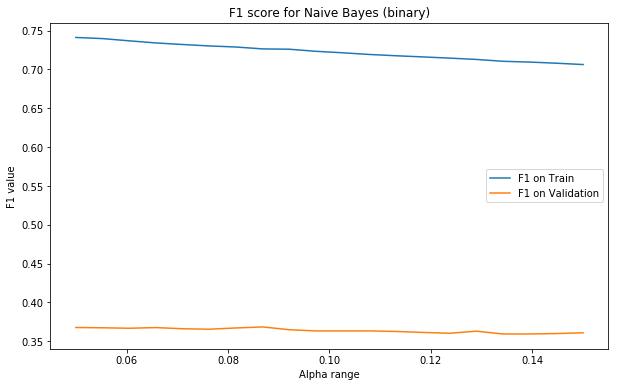

In [129]:
print "Train perfomance with best C of valid-set is", alpha_NaivaB[np.argmax(F1_NaiveB[1])], "with value ",F1_NaiveB[0][np.argmax(F1_NaiveB[1])]
print "Max of F1 for validation seat is", alpha_NaivaB[np.argmax(F1_NaiveB[1])],"with value ",F1_NaiveB[1][np.argmax(F1_NaiveB[1])]
print "Test perfomance with best C of valid-set is ", alpha_NaivaB[np.argmax(F1_NaiveB[1])],"with value ",F1_NaiveB[2][np.argmax(F1_NaiveB[1])]
showResutlsTVT(alpha_NaivaB,F1_NaiveB,["F1 score for Naive Bayes (binary)","Alpha range"])

## Decision Tree for binary

In [89]:
clf = DecisionTreeClassifier()
myTree = clf.fit(binaryTrainDS, yelpTrainY)
print myTree.tree_.max_depth
print myTree.tree_.max_n_classes
print myTree.tree_.capacity

73
5
4257


In [140]:
start_time = time.time()
depth_DTB = np.arange(40,60,2)
size =depth_DTB.shape[0]
F1_DTB    = np.zeros((3,size),dtype=float)
for i in range(size):
    clf = DecisionTreeClassifier(max_depth=depth_DTB[i],random_state=2)
    myTree = clf.fit(binaryTrainDS, yelpTrainY)
    result = clf.predict(binaryTrainDS);
    F1_DTB[0][i] = f1_score(y_true=yelpTrainY, y_pred=result, average='macro')  
    result = clf.predict(binaryValidDS);
    F1_DTB[1][i] = f1_score(y_true=yelpValY, y_pred=result, average='macro')  
    result = clf.predict(binaryTestDS);
    F1_DTB[2][i] = f1_score(y_true=yelpTestY, y_pred=result, average='macro')
    print i
    
print("--- %s seconds ---" % (time.time() - start_time))

0
1
2
3
4
5
6
7
8
9
--- 66.4115879536 seconds ---


Train perfomance with best depth of valid-set is  48 with value  0.9909463528631643
Max of F1 for validation set is with depth 48 with value  0.2869381401130229
Test perfomance with best depth of valid-set is  48 with value  0.2863919248530676


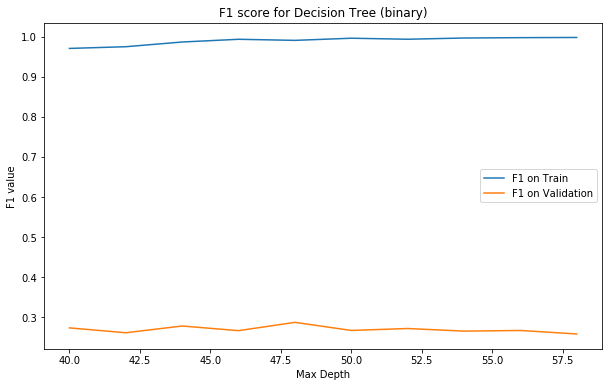

[ 10  13  19  26  37  51  71 100]


In [141]:
#print 'The depth of the tree is ',myTree.tree_.max_depth
print "Train perfomance with best depth of valid-set is ", depth_DTB[np.argmax(F1_DTB[1])], "with value ",F1_DTB[0][np.argmax(F1_DTB[1])]
print "Max of F1 for validation set is with depth", depth_DTB[np.argmax(F1_DTB[1])],"with value ",F1_DTB[1][np.argmax(F1_DTB[1])]
print "Test perfomance with best depth of valid-set is ", depth_DTB[np.argmax(F1_DTB[1])],"with value ",F1_DTB[2][np.argmax(F1_DTB[1])]
showResutlsTVT(depth_DTB,F1_DTB,["F1 score for Decision Tree (binary)","Max Depth"])
print np.logspace(1.0, 2.0, num=8, dtype=int)

In [138]:
start_time = time.time()
val = np.concatenate((np.full(binaryTrainDS.shape[0],-1),np.full(binaryValidDS.shape[0],1)))
tempDS = np.concatenate((binaryTrainDS,binaryValidDS),axis=0)
tempDSY= np.concatenate((yelpTrainY,yelpValY),axis=0)
print tempDS.shape
print tempDSY.shape
ps = PredefinedSplit(val)
param_grid = {'max_depth': np.arange(20,30,2)
              #,'criterion': ['gini','entropy']
              #,'max_leaf_nodes': np.arange(10,100,10)
              #,"min_samples_split": np.logspace(1.2, 2.0, num=7, dtype=int)
              ,'random_state': np.arange(2,3,1)
             }
clf = DecisionTreeClassifier()
tree = GridSearchCV(clf, param_grid , cv=ps ,n_jobs=8,refit=True)
tree.fit(tempDS, tempDSY)
#tree_preds = tree.predict(binaryTestDS);
tree_preds = tree.best_estimator_;
tree_preds.fit(binaryTrainDS, yelpTrainY)
result = tree_preds.predict(binaryTestDS);
print("--- %s seconds ---" % (time.time() - start_time))

(8000, 10000)
(8000, 1)
--- 33.0374159813 seconds ---


In [132]:
print np.arange(2,3,1)
print "Max F1 score is " , f1_score(y_true=yelpTestY, y_pred=result, average='macro')
print tree.best_params_


[2]
Max F1 score is  0.2823488631325507
{'random_state': 2, 'max_depth': 20}


In [71]:
clf = DecisionTreeClassifier(max_depth=24,random_state=2)
myTree = clf.fit(tempDS, tempDSY)
result = clf.predict(binaryTestDS);
print "Max F1 score is " , f1_score(y_true=yelpTestY, y_pred=result, average='macro') 


Max F1 score is  0.27762050860243787


## Linear SVM for classification

In [145]:
start_time = time.time()
C_SVMB = np.arange(0.01, 0.2, 0.005)
size =C_SVMB.shape[0]
F1_SVMB    = np.zeros((3,size),dtype=float)
for i in range(size):
    clf = LinearSVC(C=C_SVMB[i])
    clf.fit(binaryTrainDS, yelpTrainY)
    result = clf.predict(binaryTrainDS);
    F1_SVMB[0][i] = f1_score(y_true=yelpTrainY, y_pred=result, average='macro')  
    result = clf.predict(binaryValidDS);
    F1_SVMB[1][i] = f1_score(y_true=yelpValY, y_pred=result, average='macro')  
    result = clf.predict(binaryTestDS);
    F1_SVMB[2][i] = f1_score(y_true=yelpTestY, y_pred=result, average='macro')  
print("--- %s seconds ---" % (time.time() - start_time))

--- 42.8683769703 seconds ---


Train perfomance with best depth of valid-set is  0.01 with value  0.8538033114654651
Max of F1 for validation set C = 0.01 with value  0.45303985749588066
Test perfomance with best C of valid-set is  0.01 with value  0.4616633249682514


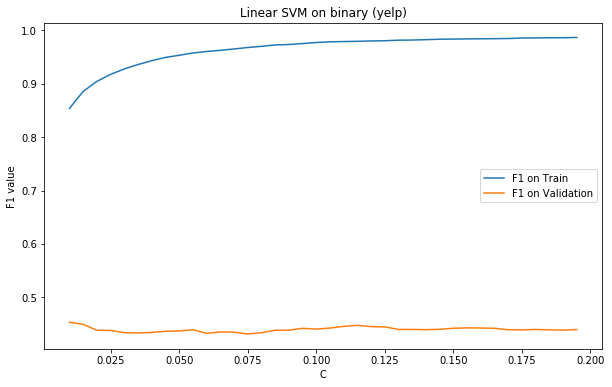

In [146]:
print "Train perfomance with best depth of valid-set is ", C_SVMB[np.argmax(F1_SVMB[1])], "with value ",F1_SVMB[0][np.argmax(F1_SVMB[1])]
print "Max of F1 for validation set C =", C_SVMB[np.argmax(F1_SVMB[1])],"with value ",F1_SVMB[1][np.argmax(F1_SVMB[1])]
print "Test perfomance with best C of valid-set is ", C_SVMB[np.argmax(F1_SVMB[1])],"with value ",F1_SVMB[2][np.argmax(F1_SVMB[1])]
showResutlsTVT(C_SVMB,F1_SVMB,["Linear SVM on binary (yelp)","C"])

In [151]:
start_time = time.time()
val = np.concatenate((np.full(binaryTrainDS.shape[0],-1),np.full(binaryValidDS.shape[0],1)))
tempDS = np.concatenate((binaryTrainDS,binaryValidDS),axis=0)
tempDSY= np.concatenate((yelpTrainY,yelpValY),axis=0)
print tempDS.shape
print tempDSY.shape
ps = PredefinedSplit(val)
param_grid = {'C': np.arange(0.01, 0.2, 0.005)
              #,'criterion': ['gini','entropy']
              #,'max_leaf_nodes': np.arange(10,100,10)
              #,"min_samples_split": np.logspace(1.2, 2.0, num=7, dtype=int)
              ,'penalty': ['l1','l2']
              ,'dual': [False]
             }
clf = LinearSVC()
tree = GridSearchCV(clf, param_grid , cv=ps ,n_jobs=8,refit=True)
tree.fit(tempDS, tempDSY)
#tree_preds = tree.predict(binaryTestDS);
tree_preds = tree.best_estimator_;
tree_preds.fit(binaryTrainDS, yelpTrainY)
result = tree_preds.predict(binaryTestDS);
print("--- %s seconds ---" % (time.time() - start_time))

(8000, 10000)
(8000, 1)
--- 185.813855171 seconds ---


In [152]:
print "Max F1 score is " , f1_score(y_true=yelpTestY, y_pred=result, average='macro')
print tree.best_params_

Max F1 score is  0.4474202633807634
{'penalty': 'l1', 'C': 0.175, 'dual': False}


## Naive Bayes for frequency bagging

In [153]:
freqTrainDS = np.copy(datasetTrain).astype(float)
temp = np.sum(freqTrainDS,axis=1)
for i in range(freqTrainDS.shape[0]):
    freqTrainDS[i]= freqTrainDS[i][:]/temp[i]

freqValidDS = np.copy(datasetValid).astype(float);
temp = np.sum(freqValidDS,axis=1)
for i in range(freqValidDS.shape[0]):
    freqValidDS[i] = freqValidDS[i][:]/temp[i]

freqTestDS = np.copy(datasetTest).astype(float);
temp = np.sum(freqTestDS,axis=1)
for i in range(freqTestDS.shape[0]):
    freqTestDS[i] = freqTestDS[i][:]/temp[i]

freqTrainDS[(np.isnan(freqTrainDS))] =0
freqValidDS[(np.isnan(freqValidDS))] =0
freqTestDS[(np.isnan(freqTestDS))]   =0

print 'Done...'

/home/mehrzad/Softwares/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in divide
  after removing the cwd from sys.path.


Done...


In [154]:
# Gaussian Naive Bayes
F1_NBG    = np.zeros((3),dtype=float)
clf = GaussianNB()
clf.fit(freqTrainDS, yelpTrainY)
result = clf.predict(freqTrainDS);
F1_NBG[0] = f1_score(y_true=yelpTrainY, y_pred=result, average='macro')  
result = clf.predict(freqValidDS);
#computeAccuracyMC(result,yelpValY,True,targets);
F1_NBG[1] = f1_score(y_true=yelpValY, y_pred=result, average='macro')  
result = clf.predict(freqTestDS);
#computeAccuracyMC(result,yelpTestY,True,targets);
F1_NBG[2] = f1_score(y_true=yelpTestY, y_pred=result, average='macro')
print 'Done..'

Done..


In [155]:
print 'F1 for training is ',F1_NBG[0]
print 'F1 for test is ',F1_NBG[1]
print 'F1 for validation is ',F1_NBG[2]

F1 for training is  0.7858270487968189
F1 for test is  0.24466026378053188
F1 for validation is  0.25489579206868906


## Decision Tree for frequency

In [170]:
clf = DecisionTreeClassifier()
myTree = clf.fit(freqTrainDS, yelpTrainY)
print myTree.tree_.max_depth
print myTree.tree_.max_n_classes
print myTree.tree_.capacity

74
5
3587


In [177]:
start_time = time.time()
depth_DTF = np.arange(7,20,2)
size =depth_DTF.shape[0]
F1_DTF    = np.zeros((3,size),dtype=float)
for i in range(size):
    clf = DecisionTreeClassifier(max_depth=depth_DTF[i])
    myTree = clf.fit(freqTrainDS, yelpTrainY)
    result = clf.predict(freqTrainDS);
    F1_DTF[0][i] = f1_score(y_true=yelpTrainY, y_pred=result, average='macro')  
    result = clf.predict(freqValidDS);
    F1_DTF[1][i] = f1_score(y_true=yelpValY, y_pred=result, average='macro')  
    result = clf.predict(freqTestDS);
    F1_DTF[2][i] = f1_score(y_true=yelpTestY, y_pred=result, average='macro')  
    print i
print("--- %s seconds ---" % (time.time() - start_time))

0
1
2
3
4
5
6
--- 38.66726017 seconds ---


Train perfomance with best depth of valid-set is  13 with value  0.5678169120747514
Max of F1 for validation set is with depth 13 with value  0.31370289618570535
Test perfomance with best depth of valid-set is  13 with value  0.2795426344157252


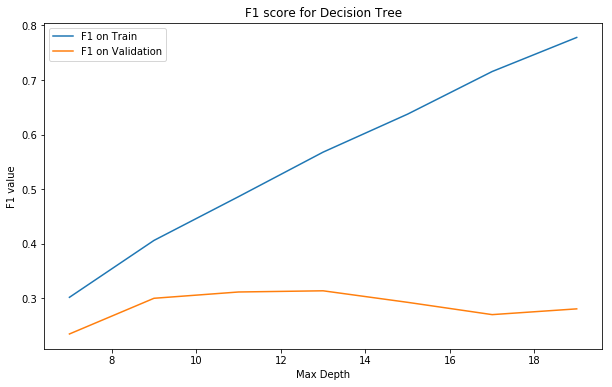

In [178]:
#print 'The depth of the tree is ',myTree.tree_.max_depth
print "Train perfomance with best depth of valid-set is ", depth_DTF[np.argmax(F1_DTF[1])], "with value ",F1_DTF[0][np.argmax(F1_DTF[1])]
print "Max of F1 for validation set is with depth", depth_DTF[np.argmax(F1_DTF[1])],"with value ",F1_DTF[1][np.argmax(F1_DTF[1])]
print "Test perfomance with best depth of valid-set is ", depth_DTF[np.argmax(F1_DTF[1])],"with value ",F1_DTF[2][np.argmax(F1_DTF[1])]
showResutlsTVT(depth_DTF,F1_DTF,["F1 score for Decision Tree","Max Depth"])

## Linear SVM for frequency

In [174]:
start_time = time.time()
C_SVMF = np.arange(50, 150, 10)
size =C_SVMF.shape[0]
F1_SVMF    = np.zeros((3,size),dtype=float)
for i in range(size):
    clf = LinearSVC(C=C_SVMF[i])
    clf.fit(freqTrainDS, yelpTrainY)
    result = clf.predict(freqTrainDS);
    F1_SVMF[0][i] = f1_score(y_true=yelpTrainY, y_pred=result, average='macro')  
    result = clf.predict(freqValidDS);
    F1_SVMF[1][i] = f1_score(y_true=yelpValY, y_pred=result, average='macro')  
    result = clf.predict(freqTestDS);
    F1_SVMF[2][i] = f1_score(y_true=yelpTestY, y_pred=result, average='macro')  
    print i
print("--- %s seconds ---" % (time.time() - start_time))

0
1
2
3
4
5
6
7
8
9
--- 77.4111950397 seconds ---


Train perfomance with best depth of valid-set is  120 with value  0.9077481027515455
Max of F1 for validation set, C is 120 with value  0.4735082488040493
Test perfomance with best depth of valid-set is  120 with value  0.45657522234875214


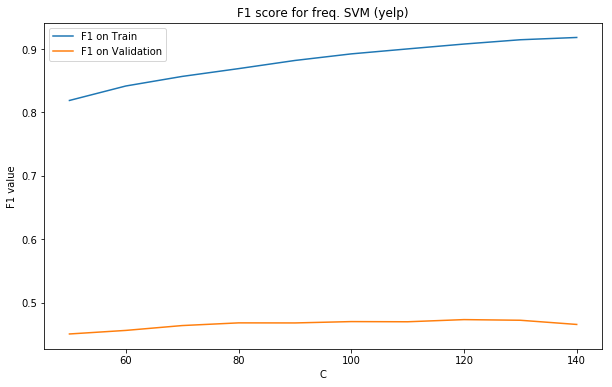

In [167]:
#print 'The depth of the tree is ',myTree.tree_.max_depth
print "Train perfomance with best depth of valid-set is ", C_SVMF[np.argmax(F1_SVMF[1])], "with value ",F1_SVMF[0][np.argmax(F1_SVMF[1])]
print "Max of F1 for validation set, C is", C_SVMF[np.argmax(F1_SVMF[1])],"with value ",F1_SVMF[1][np.argmax(F1_SVMF[1])]
print "Test perfomance with best depth of valid-set is ", C_SVMF[np.argmax(F1_SVMF[1])],"with value ",F1_SVMF[2][np.argmax(F1_SVMF[1])]
showResutlsTVT(C_SVMF,F1_SVMF,["F1 score for freq. SVM (yelp)","C"])

## Submitting dataset

In [ ]:
## vocab.txt
a1_sorted_keys = sorted(features, key=dictionary.get, reverse=True)
counter =1
file = open("./myFiles/yelp-vocab.txt","w") 
for r in a1_sorted_keys:
    text = str(r) + '\t' + str(counter) + '\t' + str(dictionary[r]) + '\n'
    file.write(text)  
    counter+=1
print 'Done...'


In [ ]:
def writeFiles(Name,ds,ds_y,features):
    file = open("myFiles/"+Name,"w") 
    for i in range(len(ds)):
        words = np.array((ds[i].split(' ')))
        text = ""
        for word in words:
            try:
                text += str(features.index(word)) + ' '
                #print word,features.index(word)
            except ValueError:
                text 
        text  += '\t' + str(ds_y[i][0]) + '\n'
        file.write(text)
    print 'Done...'

writeFiles("yelp-train.txt",yelpTrain,yelpTrainY,features)
writeFiles("yelp-valid.txt",yelpVal,yelpValY,features)
writeFiles("yelp-test.txt",yelpTest,yelpTestY,features)